In [1]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    RandomizedSearchCV,
    GridSearchCV,
    TimeSeriesSplit
)


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.formatter.use_locale'] = True

# Reading data

In [2]:
# reading data
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
# cleaning process
c2g_data.index = pd.to_datetime(c2g_data.index)

Selecting the period that has less missing data between the three services.

In [4]:
init_period = '2016-12-13 15:00'
end_period = '2017-02-25 17:00'

c2g_data = c2g_data[(c2g_data.index >= init_period) & (c2g_data.index <= end_period)]

In [5]:
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [6]:
PAST_LAGS = 24
FUTURE_LAGS = 12
TRAIN_VAL_SPLIT = 0.7
VAL_TEST_SPLIT = 0.8

In [7]:
def gen_supervised_learning(df, past_lags, future_lags):
    X = df.copy()
    for lag in range(1, past_lags):
        X = X.join(df.shift(lag), rsuffix=f'_t-{lag}')
    
    y = pd.DataFrame(df.travels.copy())
    for lag in range(1, future_lags):
        y = y.join(df.travels.shift(lag), rsuffix=f'_t-{lag}')
        
    X = X.shift(future_lags)
    
    return X.iloc[past_lags + future_lags:], y.iloc[past_lags + future_lags:]

In [8]:
uni_set = pd.DataFrame(c2g_data.travels)
X, y = gen_supervised_learning(uni_set, PAST_LAGS, 1)

In [9]:
# reordering columns
columns = ['travels_t-23', 'travels_t-22', 'travels_t-21', 'travels_t-20',
       'travels_t-19', 'travels_t-18', 'travels_t-17', 'travels_t-16',
       'travels_t-15', 'travels_t-14', 'travels_t-13', 'travels_t-12',
       'travels_t-11', 'travels_t-10', 'travels_t-9', 'travels_t-8',
       'travels_t-7', 'travels_t-6', 'travels_t-5', 'travels_t-4',
       'travels_t-3', 'travels_t-2', 'travels_t-1', 'travels']

X = X[columns]

In [10]:
# splitting in train (80%) and test data (20%)
def splitter(data, ratio):
    size = len(data)
    data_train = data.iloc[:int(ratio[0]*size)]
    data_val = data.iloc[int(ratio[0]*size):int(ratio[1]*size)]
    data_test = data.iloc[int(ratio[1]*size):]
    return data_train, data_val, data_test

In [11]:
X_train, X_val, X_test = splitter(X, [TRAIN_VAL_SPLIT, VAL_TEST_SPLIT])
y_train, y_val, y_test = splitter(y, [TRAIN_VAL_SPLIT, VAL_TEST_SPLIT])

## Grid Search

In [11]:
xgb_params = {
    'njobs':[4],
    'objective':['reg:squarederror'],
    'eval_metric': ['rmse'],
    'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.1],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [1000, 2000, 3000, 5000],
    'random_state': [42]
}

In [102]:
tscv = TimeSeriesSplit(n_splits=4)
gsearch = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(),
    cv=tscv, param_distributions=xgb_params,
    scoring='neg_mean_absolute_error',
    n_iter=20,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
fit_params = {
    'eval_set':[(X_val, y_val)],
}

### Fitting

In [103]:
gsearch.fit(X_train, y_train, **fit_params)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min


[0]	validation_0-rmse:130.244
[1]	validation_0-rmse:129.604
[2]	validation_0-rmse:128.951
[3]	validation_0-rmse:128.296
[4]	validation_0-rmse:127.649
[5]	validation_0-rmse:127.002
[6]	validation_0-rmse:126.382
[7]	validation_0-rmse:125.75
[8]	validation_0-rmse:125.128
[9]	validation_0-rmse:124.516
[10]	validation_0-rmse:123.921
[11]	validation_0-rmse:123.3
[12]	validation_0-rmse:122.673
[13]	validation_0-rmse:122.071
[14]	validation_0-rmse:121.458
[15]	validation_0-rmse:120.832
[16]	validation_0-rmse:120.203
[17]	validation_0-rmse:119.601
[18]	validation_0-rmse:119.025
[19]	validation_0-rmse:118.43
[20]	validation_0-rmse:117.828
[21]	validation_0-rmse:117.226
[22]	validation_0-rmse:116.629
[23]	validation_0-rmse:116.043


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.6min finished


[24]	validation_0-rmse:115.461
[25]	validation_0-rmse:114.894
[26]	validation_0-rmse:114.32
[27]	validation_0-rmse:113.752
[28]	validation_0-rmse:113.171
[29]	validation_0-rmse:112.606
[30]	validation_0-rmse:112.039
[31]	validation_0-rmse:111.499
[32]	validation_0-rmse:110.957
[33]	validation_0-rmse:110.383
[34]	validation_0-rmse:109.831
[35]	validation_0-rmse:109.308
[36]	validation_0-rmse:108.763
[37]	validation_0-rmse:108.222
[38]	validation_0-rmse:107.68
[39]	validation_0-rmse:107.126
[40]	validation_0-rmse:106.589
[41]	validation_0-rmse:106.03
[42]	validation_0-rmse:105.502
[43]	validation_0-rmse:104.994
[44]	validation_0-rmse:104.469
[45]	validation_0-rmse:103.943
[46]	validation_0-rmse:103.432
[47]	validation_0-rmse:102.94
[48]	validation_0-rmse:102.434
[49]	validation_0-rmse:101.94
[50]	validation_0-rmse:101.436
[51]	validation_0-rmse:100.919
[52]	validation_0-rmse:100.422
[53]	validation_0-rmse:99.9271
[54]	validation_0-rmse:99.4538
[55]	validation_0-rmse:98.9721
[56]	validati

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
                   error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          ob...
                                        'learning_rate': [0.003, 0.005, 0.01,
                                                          0.03, 0.05, 0.1],
                                        'max_depth': [4, 5

In [104]:
gsearch.best_params_

{'colsample_bytree': 1,
 'eval_metric': 'rmse',
 'learning_rate': 0.005,
 'max_depth': 10,
 'min_child_weight': 8,
 'n_estimators': 2000,
 'njobs': 4,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'subsample': 0.5}

In [105]:
gsearch.best_score_

-15.983450978629444

## Testing models

In [12]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 
            'corr':corr, 'minmax':minmax})

In [50]:
def plot_test_forecast(model, train, X_test, y_test):
    # Forecast
    fc = model.predict(X_test.values)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train.index, train.travels, label='train')
    plt.plot(y_test.index, y_test.travels, label='test')
    plt.plot(y_test.index, fc, color='darkgreen', label='forecast')
    plt.legend(loc='upper left', fontsize=8)
    plt.title('Forecast vs Actuals')
    plt.show()

In [14]:
def auto_feed(model, to_predict, period):
    predictions = []
    for _ in range(period):

        prediction = model.predict([to_predict])
        predictions.append(prediction[0])

        # removing the first input and adding the prediction to the end
        to_predict[:-1] = to_predict[1:]
        to_predict[-1] = prediction
        
    return predictions

In [15]:
def test_auto_feed(model, X_train, y_train, X_test, y_test, train_period=24, predict_period=12, path=None):
    """
    Test prediction of the next period in hours.
    In this test each predicted value is included in the training set before the new prediction
    As default it will predict the first 12 hours of the test dataset.
    """
    
    model.fit(X_train.values, y_train.values)
    
    total_predictions = []
    test_values = []
    for i in range(len(X_test)-predict_period):
        X_to_test, y_to_test = X_test[i:predict_period+i].copy(), y_test[i:predict_period+i].copy()

        to_predict = np.array(X_to_test.iloc[0])

        index = y_to_test.index
        test_values.append(y_to_test.travels.values)

        predictions = auto_feed(model, X_to_test.iloc[0].values, predict_period)
        
        total_predictions.append(predictions)
    
    test_values = np.array(test_values)
    total_predictions = np.array(total_predictions)
    results = (test_values, total_predictions)
    print(test_values.shape)
    print(total_predictions.shape)
    pickle.dump(results, open( path+"auto_feed_results.p", "wb" ))
    
    return results

In [16]:
def test_future_period(model, X_train, y_train, X_test, y_test, predict_period=168, path=None):
    """
    Test prediction of a future period.
    In this test each already tested period is included in the training set before the new prediction
    As default it will predict the first week of the test dataset.
    """
    
    X_to_train, y_to_train = X_train.copy(), y_train.copy()

    model.fit(X_to_train.values, y_to_train.values)

#     index = y_to_test.index
    test_values = []
    final_predictions = []
    for i in range(len(X_test)-predict_period):
        X_to_test, y_to_test = X_test[i:predict_period+i].copy(), y_test[i:i+predict_period].copy()

        test_values.append(y_to_test.travels.values)

        predictions = auto_feed(model, X_to_test.iloc[0].values, predict_period)
        
        final_predictions.append(predictions)
    
    test_values = np.array(test_values)
    final_predictions = np.array(final_predictions)
    results = (test_values, final_predictions)
    print(test_values.shape)
    print(final_predictions.shape)
    pickle.dump(results, open( path+"future_period_results.p", "wb" ))
    
    return results

In [17]:
c2g_params = {
    'colsample_bytree': 1,
    'eval_metric': 'rmse',
    'learning_rate': 0.005,
    'max_depth': 10,
    'min_child_weight': 8,
    'n_estimators': 2000,
    'njobs': 4,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'subsample': 0.5
}

### XGBoost

In [18]:
xgb_model = xgb.XGBRegressor(**c2g_params)

In [19]:
xgb_model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
       importance_type='gain', learning_rate=0.005, max_delta_step=0,
       max_depth=10, min_child_weight=8, missing=None, n_estimators=2000,
       n_jobs=1, njobs=4, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.5, verbosity=1)

In [47]:
c2g_fc = xgb_model.predict(X_test.values)

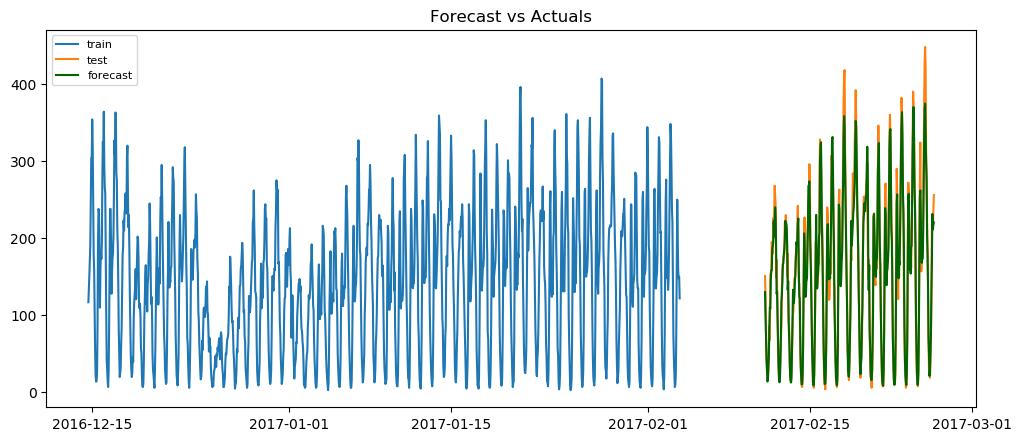

In [115]:
plot_test_forecast(c2g_model, X_train, X_test, y_test)

In [117]:
forecast_accuracy(c2g_fc, X_test.travels)

{'corr': 0.9286764956989288,
 'mae': 29.34929664046676,
 'mape': 0.3566269444119919,
 'me': -3.7760156756452687,
 'minmax': 0.2263069657767408,
 'mpe': 0.11964411817387847,
 'mse': 1441.8612504226667}

In [20]:
xgb_auto_feed = test_auto_feed(
    xgb_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/xgboost/'
)

(339, 12)
(339, 12)


In [21]:
xgb_future_period = test_future_period(
    xgb_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/xgboost/'
)

(183, 168)
(183, 168)


## Variants:

The variant models where develop on other notebooks

### CatBoost

In [22]:
from catboost import CatBoostRegressor, Pool

In [23]:
cat_model = pickle.load(open( 'JISA/catboost/c2g_model_catboost.sav', "rb" ))

In [24]:
cat_auto_feed = test_auto_feed(
    cat_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/catboost/'
)

0:	learn: 74.6180145	total: 81.1ms	remaining: 20m 16s
1:	learn: 74.2885366	total: 88.8ms	remaining: 11m 6s
2:	learn: 73.9676706	total: 95.7ms	remaining: 7m 58s
3:	learn: 73.6368030	total: 104ms	remaining: 6m 29s
4:	learn: 73.3151211	total: 111ms	remaining: 5m 32s
5:	learn: 73.0064199	total: 120ms	remaining: 5m
6:	learn: 72.6856654	total: 128ms	remaining: 4m 33s
7:	learn: 72.3474602	total: 136ms	remaining: 4m 15s
8:	learn: 72.0343099	total: 143ms	remaining: 3m 58s
9:	learn: 71.7184661	total: 151ms	remaining: 3m 46s
10:	learn: 71.4039569	total: 158ms	remaining: 3m 35s
11:	learn: 71.0942511	total: 165ms	remaining: 3m 25s
12:	learn: 70.7972435	total: 173ms	remaining: 3m 19s
13:	learn: 70.5056613	total: 180ms	remaining: 3m 13s
14:	learn: 70.2010559	total: 189ms	remaining: 3m 8s
15:	learn: 69.8984804	total: 196ms	remaining: 3m 3s
16:	learn: 69.6016616	total: 204ms	remaining: 2m 59s
17:	learn: 69.2895882	total: 210ms	remaining: 2m 55s
18:	learn: 68.9860014	total: 217ms	remaining: 2m 51s
19:	l

In [25]:
cat_future_period = test_future_period(
    cat_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/catboost/'
)

0:	learn: 74.6180145	total: 7.95ms	remaining: 1m 59s
1:	learn: 74.2885366	total: 14.7ms	remaining: 1m 50s
2:	learn: 73.9676706	total: 23.6ms	remaining: 1m 57s
3:	learn: 73.6368030	total: 31.1ms	remaining: 1m 56s
4:	learn: 73.3151211	total: 37.6ms	remaining: 1m 52s
5:	learn: 73.0064199	total: 44.6ms	remaining: 1m 51s
6:	learn: 72.6856654	total: 51.3ms	remaining: 1m 49s
7:	learn: 72.3474602	total: 58.3ms	remaining: 1m 49s
8:	learn: 72.0343099	total: 65.3ms	remaining: 1m 48s
9:	learn: 71.7184661	total: 72.3ms	remaining: 1m 48s
10:	learn: 71.4039569	total: 79.2ms	remaining: 1m 47s
11:	learn: 71.0942511	total: 86ms	remaining: 1m 47s
12:	learn: 70.7972435	total: 93.1ms	remaining: 1m 47s
13:	learn: 70.5056613	total: 99.8ms	remaining: 1m 46s
14:	learn: 70.2010559	total: 107ms	remaining: 1m 46s
15:	learn: 69.8984804	total: 114ms	remaining: 1m 46s
16:	learn: 69.6016616	total: 121ms	remaining: 1m 46s
17:	learn: 69.2895882	total: 127ms	remaining: 1m 45s
18:	learn: 68.9860014	total: 134ms	remaining

### Light_gbm

In [26]:
light_gbm_model = pickle.load(open( 'JISA/light_gbm/c2g_model_light_gbm.sav', "rb" ))

In [27]:
light_gbm_feed = test_auto_feed(
    light_gbm_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/light_gbm/'
)

(339, 12)
(339, 12)


In [28]:
light_gbm_future_period = test_future_period(
    light_gbm_model, X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),
    path='JISA/light_gbm/'
)

(183, 168)
(183, 168)
